In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('.')
sys.path.append('./scripts')
from competing_methods_local import *
from simulations_util import *
from util import  apply_splitting_strategy
from sklearn.preprocessing import StandardScaler

/accounts/projects/binyu/zhongyuan_liang/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0

### Classification

In [3]:
task = "classification" 
combined_df = pd.DataFrame()
datasets = ['openml_361062', 'openml_361063', 'openml_361069', 'openml_361071', 'openml_43', 'openml_9978']
split_seeds = [1,2,3,4]
sample_seeds = [1,2,3,4,5]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [4]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    # 'MDI+',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'MDI+': 'red',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

<>:68: DeprecationWarning: invalid escape sequence '\%'
<>:68: DeprecationWarning: invalid escape sequence '\%'
/tmp/ipykernel_2481765/1195472698.py:68: DeprecationWarning: invalid escape sequence '\%'
  ax.set_title(r"$\mathbf{" + f"{int(percentage*100)}\% \ Top \ Features \ Retained" + r"}$", fontsize=28)
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, bac

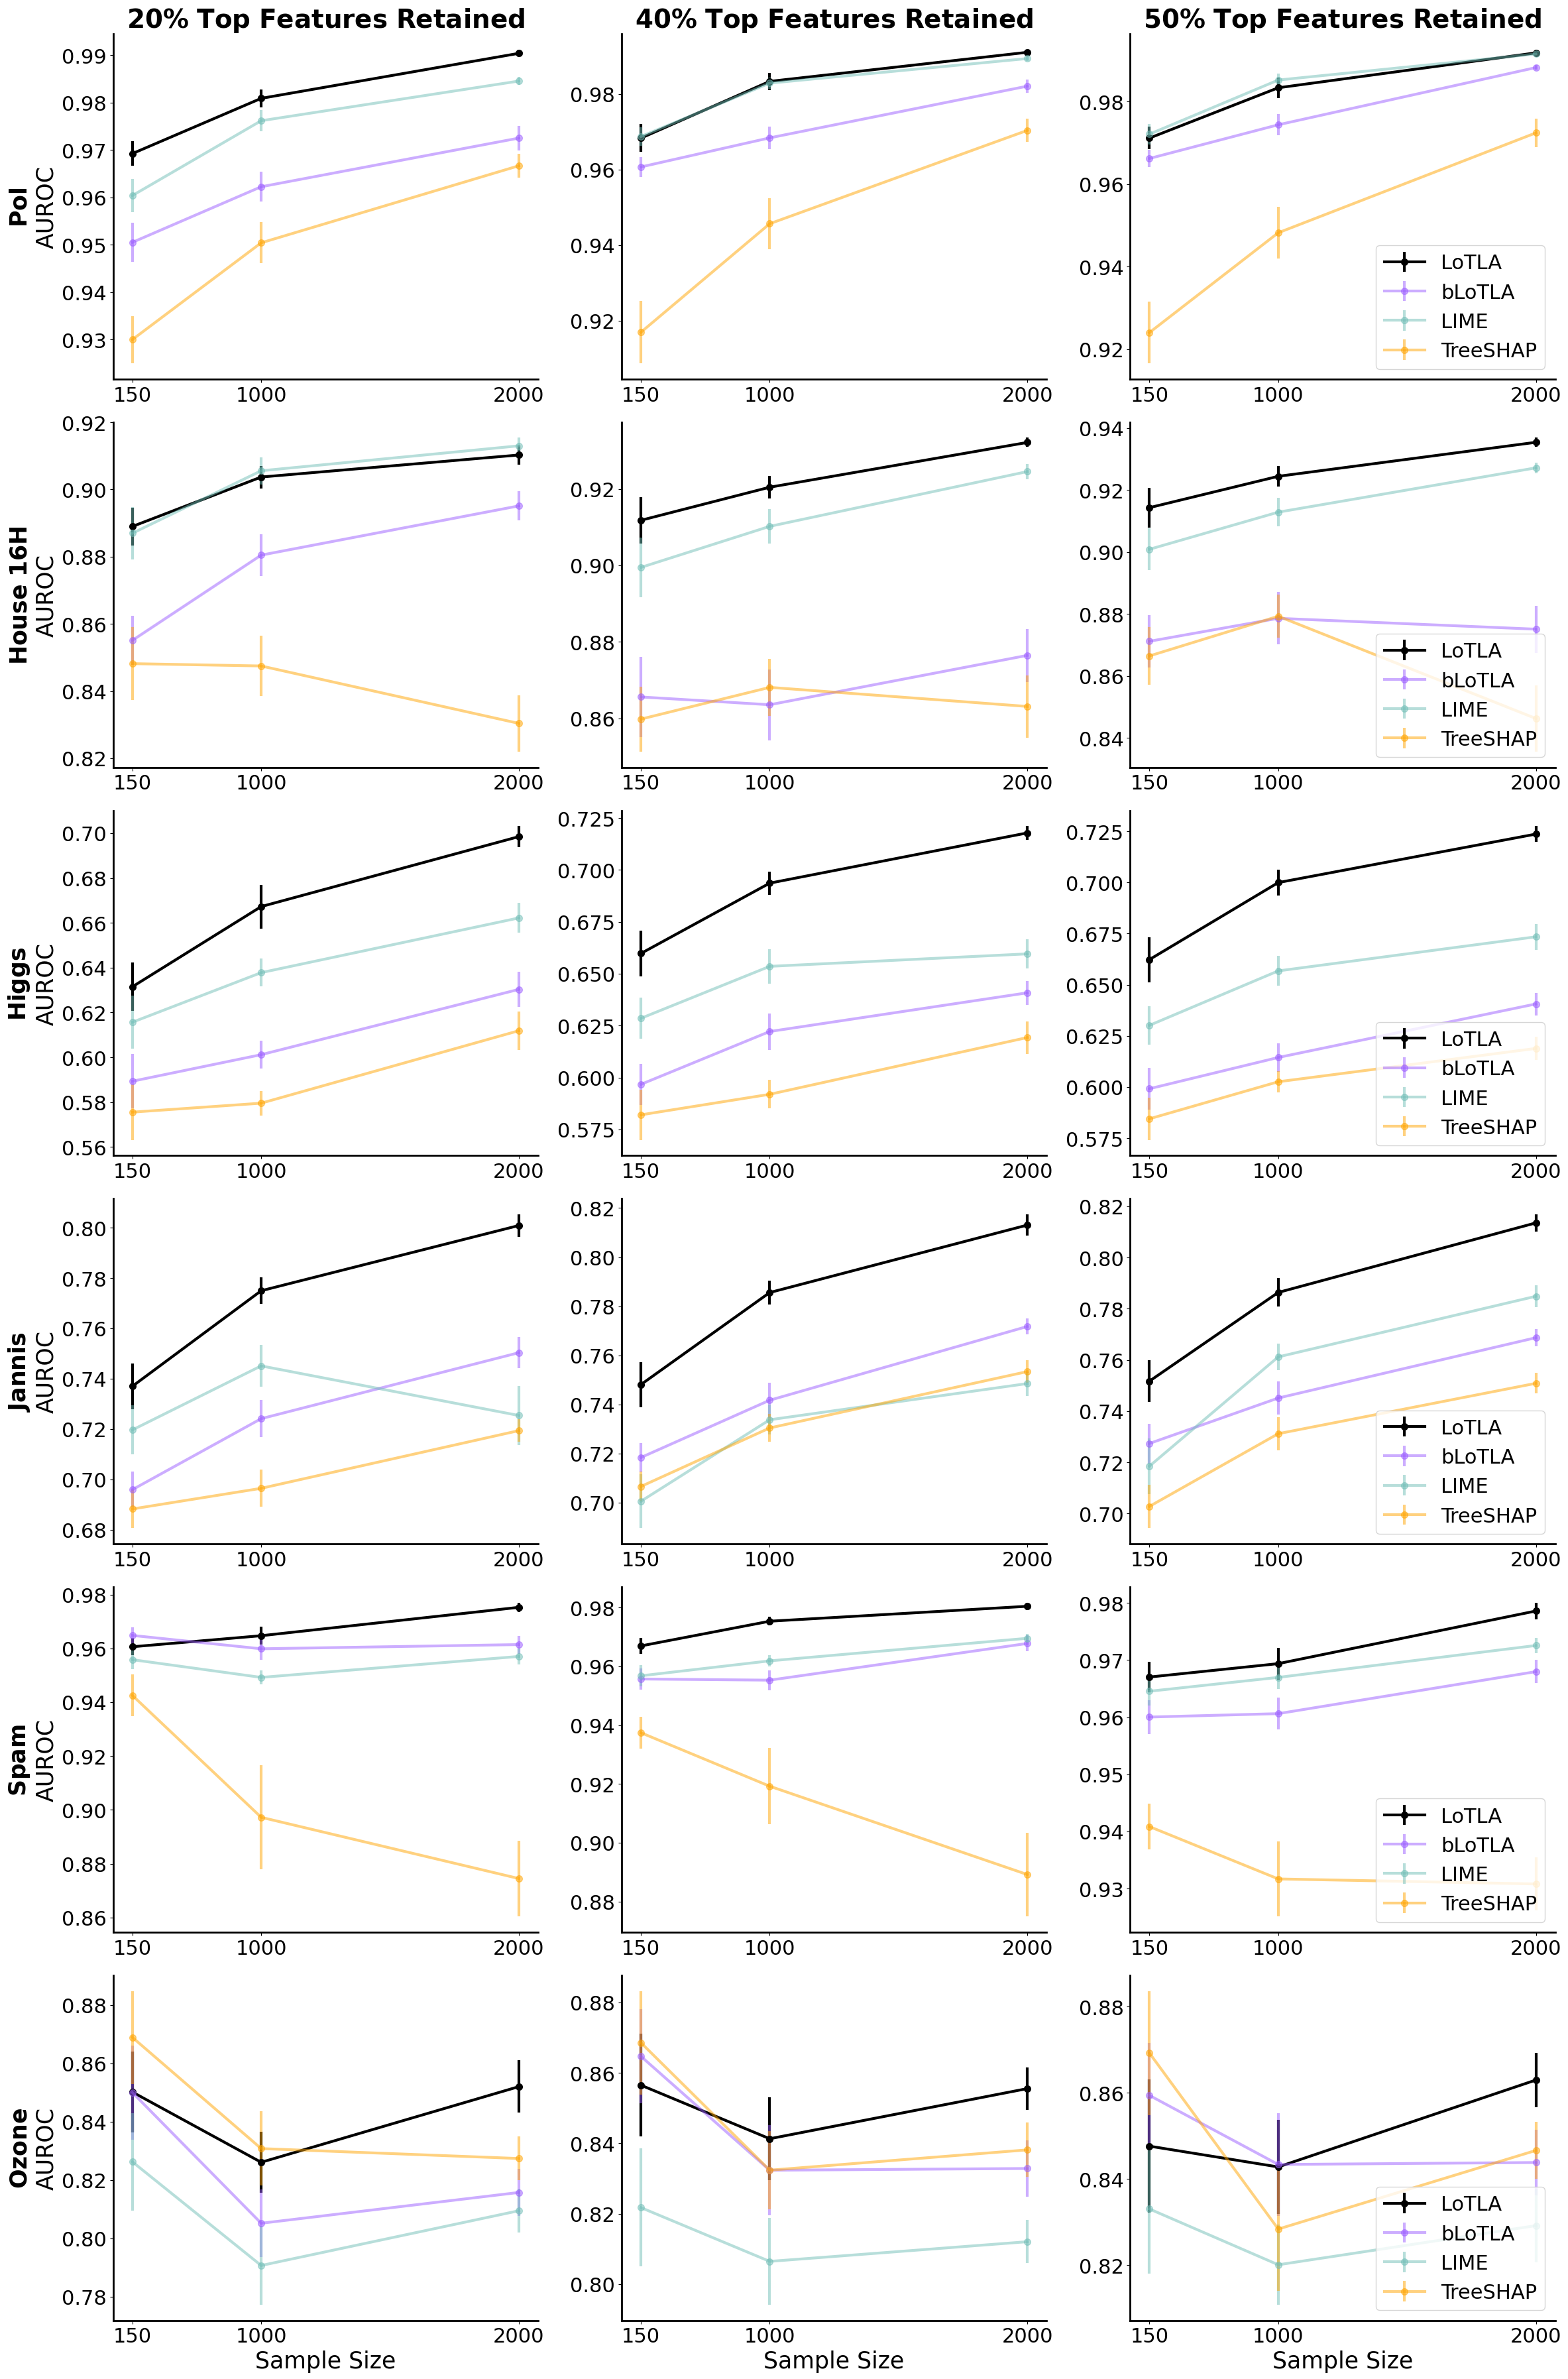

In [5]:
df = combined_df.copy()
datasets = df["data"].unique()
percentage_features_all = [0.2,0.4,0.5]

marker_size = 7
dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']

n_cols = len(percentage_features_all)
n_rows = len(datasets)

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

# axs = axs.flatten()

for row_idx, dataset in enumerate(datasets):
    for col_idx, percentage in enumerate(percentage_features_all):
        ax = axs[row_idx, col_idx]
        subset = df[df["data"] == dataset]

        for method in methods:
            method_data = subset[subset["fi"] == method]
            auroc_col = "RF_Classifier_AUROC_top_" + str(percentage)
            grouped = method_data.groupby("sample_row_n")[auroc_col]
            means = grouped.mean().values
            stds = grouped.std().values
            counts = grouped.count().values
            sems = stds / np.sqrt(counts)

            sample_row_n = grouped.mean().index.values
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
                ax.errorbar(
                    sample_row_n, means, sems,
                    label=methods_name[method], linestyle='solid',  # Only dotted lines
                    marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.errorbar(
                    sample_row_n, means, sems,
                    label=methods_name[method], linestyle='solid',  # Only solid lines
                    marker='o', markersize=marker_size, color=color_map[method], linewidth=3
                )
        

        ax.set_xticks([500,1000,2000])
        ax.set_xticklabels(["150", "1000", "2000"], fontsize=22)
        ax.tick_params(axis='y', labelsize=22)
        if row_idx == n_rows - 1: 
            ax.set_xlabel("Sample Size", fontsize=25)
        
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=25)
        else:
            ax.set_ylabel("")
        
        if row_idx == 0:
            ax.set_title(r"$\mathbf{" + f"{int(percentage*100)}\% \ Top \ Features \ Retained" + r"}$", fontsize=28)

        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

plt.tight_layout()#rect=[0, 0, 1, 0.95])
plt.savefig("feature_selection_classification_vary_sample_size.png")
plt.show()

### Regression

In [6]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ['openml_361242', 'openml_361243', 'openml_361253', 'openml_361254', 'openml_361259', 'openml_361260']
split_seeds = [1,2,3,4]
sample_seeds = [1,2,3,4,5]
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}/{data}_selection/varying_sample_row_n"
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [7]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    # 'MDI+',
    'LIME_RF',
    'TreeSHAP_RF',
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'MDI+': 'red',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361254": "SARCOS",
    "openml_361242": "Super Conductivity",
    "openml_361243": "Geographic Origin of Music"
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'MDI+': 'MDI+',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA',
}

<>:62: DeprecationWarning: invalid escape sequence '\%'
<>:62: DeprecationWarning: invalid escape sequence '\%'
/tmp/ipykernel_2481765/2546841343.py:62: DeprecationWarning: invalid escape sequence '\%'
  ax.set_title(r"$\mathbf{" + f"{int(percentage*100)}\% \ Top \ Features \ Retained" + r"}$", fontsize=28)


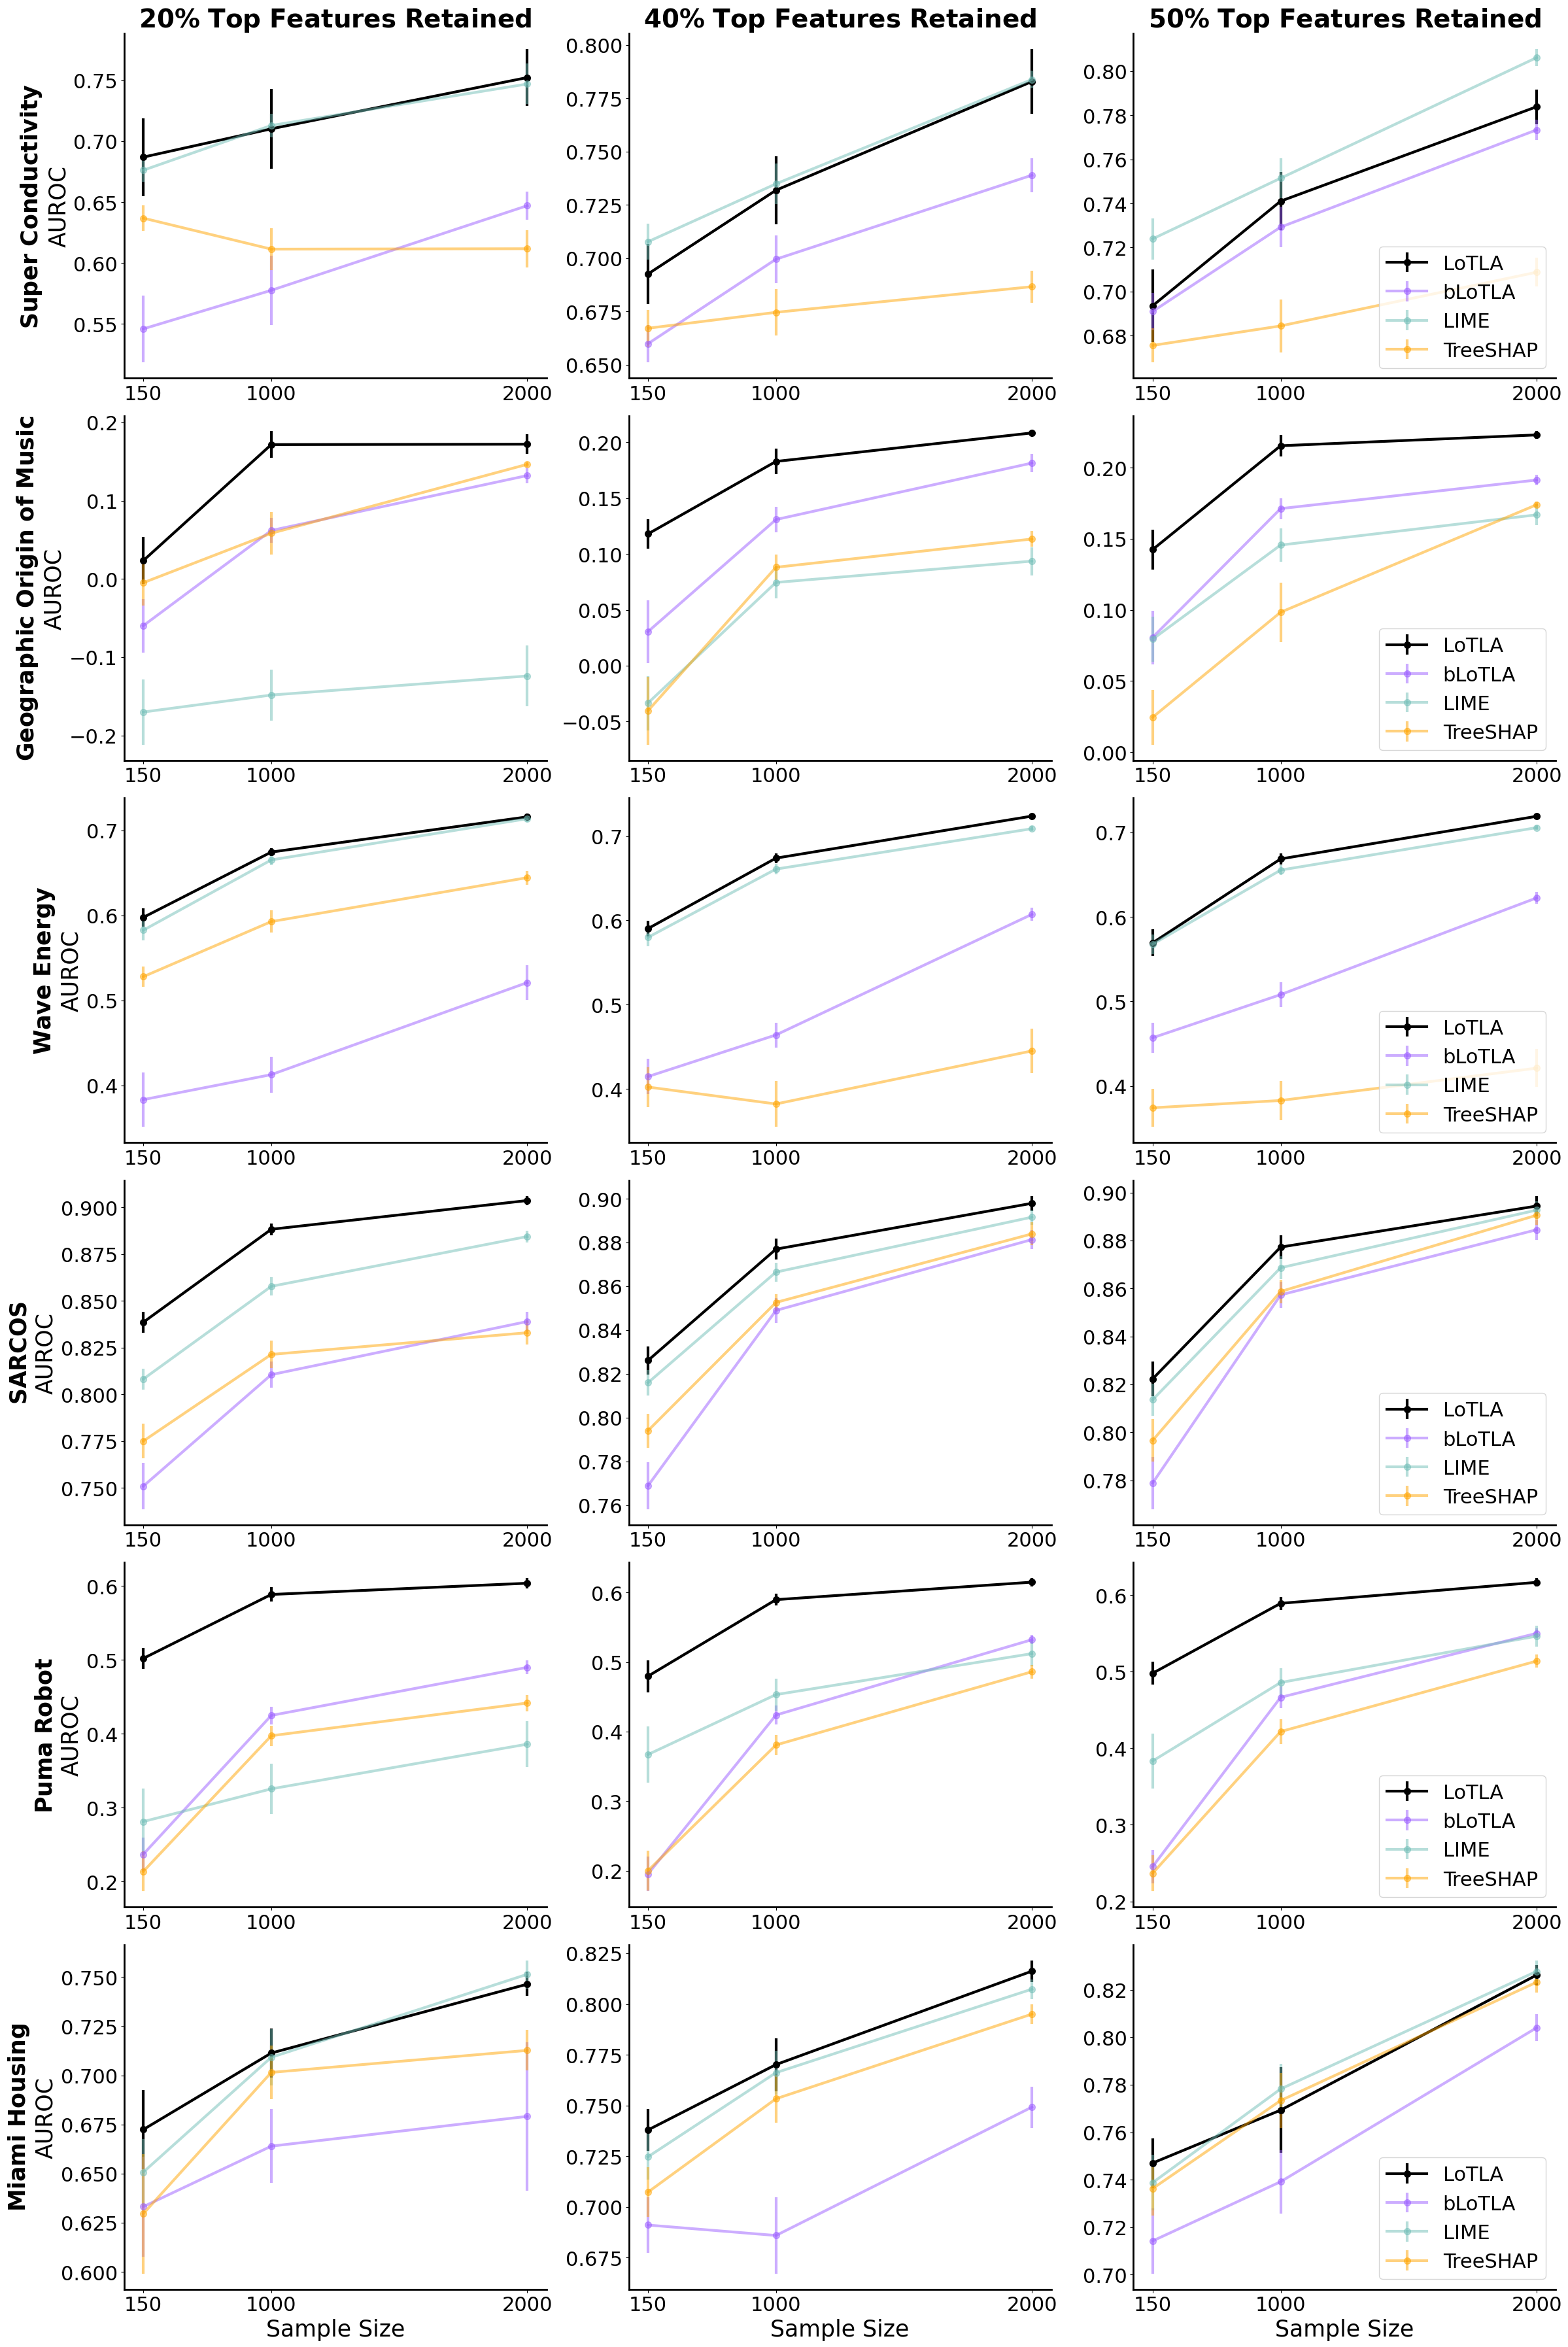

In [8]:
df = combined_df.copy()
datasets = df["data"].unique()
percentage_features_all = [0.2,0.4,0.5]
marker_size = 7
dotted_methods = ['LIME_RF', 'TreeSHAP_RF', 'MDI']

n_cols = len(percentage_features_all)
n_rows = len(datasets)

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 6 * n_rows),
    sharey=False
)

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

for row_idx, dataset in enumerate(datasets):
    for col_idx, percentage in enumerate(percentage_features_all):
        ax = axs[row_idx, col_idx]
        subset = df[df["data"] == dataset]

        for method in methods:
            method_data = subset[subset["fi"] == method]
            auroc_col = "RF_Regressor_R2_keep_" + str(percentage)
            grouped = method_data.groupby("sample_row_n")[auroc_col]
            means = grouped.mean().values
            stds = grouped.std().values
            counts = grouped.count().values
            sems = stds / np.sqrt(counts)
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI', 'MDI+']:
                ax.errorbar(
                    sample_row_n, means, sems,
                    label=methods_name[method], linestyle='solid',  # Only dotted lines
                    marker='o', markersize=marker_size, color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.errorbar(
                    sample_row_n, means, sems,
                    label=methods_name[method], linestyle='solid',  # Only solid lines
                    marker='o', markersize=marker_size, color=color_map[method], linewidth=3
                )

        ax.set_xticks([500,1000,2000])
        ax.set_xticklabels(["150", "1000", "2000"], fontsize=22)
        ax.tick_params(axis='y', labelsize=22)
        if row_idx == n_rows - 1: 
            ax.set_xlabel("Sample Size", fontsize=25)
        
        if col_idx == 0:
            dataset_label = data_name[dataset].replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}}}$\nAUROC", fontsize=25)
        else:
            ax.set_ylabel("")
        
        if row_idx == 0:
            ax.set_title(r"$\mathbf{" + f"{int(percentage*100)}\% \ Top \ Features \ Retained" + r"}$", fontsize=28)

        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

plt.tight_layout()#rect=[0, 0, 1, 0.95])
plt.savefig("feature_selection_regression_vary_sample_size.png")
plt.show()